---

# IMPORTING LYBRARIES

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time, itertools, dataframe_image as dfi, os
from datetime import datetime
from IPython.display import clear_output

import seaborn as sns; sns.set_style('darkgrid')
import pandas as pd; pd.set_option('display.max_colwidth', None) 
import warnings; warnings.filterwarnings('ignore')

from sklearn.utils import all_estimators # Machine Learning Estimators
from sklearn.preprocessing import LabelEncoder as le, MinMaxScaler as mms, StandardScaler as ss
from sklearn.linear_model import LinearRegression as lr
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedShuffleSplit as sss, train_test_split
from sklearn.metrics import (accuracy_score as acc_scr, r2_score, classification_report,
                            confusion_matrix, make_scorer, matthews_corrcoef, precision_score,
                            recall_score, f1_score, fbeta_score, precision_recall_fscore_support)
import joblib

---

# FUNCTIONS

#### Encode dataframe columns to Label, Ordinal, Float, String, Integer or Onehot type.

encode(df_copy, test_set=None, ordinal_cols=None, label_cols=None, float_cols=None, string_cols=None, int_cols=None, onehot_cols=None, concat_onehot=False, prefix_col=''):

In [2]:
def encode(df_copy, test_set=None, ordinal_cols=None, label_cols=None, float_cols=None, string_cols=None, int_cols=None, onehot_cols=None, concat_onehot=False, prefix_col=''):
    
    if type(test_set)==type(None): dfs = [df_copy.copy()]
    else: dfs = [df_copy.copy(), test_set.copy()]
    
    new_dfs = []
    for df in dfs.copy():

        if type(ordinal_cols)!=type(None):
            n_ordinals = len(ordinal_cols)
            for i, col in enumerate(ordinal_cols):
                ord_encoded_col = df[col].to_frame()
                df[col] = oe().fit(ord_encoded_col).transform(ord_encoded_col)
                clear_output(wait=True)
                print('Rotulando Variáveis Ordinais... - ', i, '/', n_ordinals)

        if type(label_cols)!=type(None):
            n_labels = len(label_cols)
            for i, col in enumerate(label_cols):

                label_encoded_col = df[col]
                df[col] = le().fit(label_encoded_col).transform(label_encoded_col)
                clear_output(wait=True)
                print('Rotulando Variáveis Categóricas... - ', i, '/', n_labels)

        if type(float_cols)!=type(None):
            n_floats = len(float_cols)
            for i, col in enumerate(float_cols):

                df[col] = df[col].astype(float)
                clear_output(wait=True)
                print('Convertendo Variáveis Para "Float"... - ', i, '/', n_floats)

        if type(string_cols)!=type(None):         
            n_strings = len(string_cols)
            for i, col in enumerate(string_cols):

                df[col] = df[col].astype(str)
                clear_output(wait=True)
                print('Convertendo Variáveis Para "String"... - ', i, '/', n_strings)

        if type(int_cols)!=type(None):         
            n_int = len(int_cols)
            for i, col in enumerate(int_cols):

                df[col] = df[col].astype(int)
                clear_output(wait=True)
                print('Convertendo Variáveis Para "String"... - ', i, '/', n_int)

        if type(onehot_cols)!=type(None):         
            n_onehot = len(onehot_cols)
            onehot_lst = []
            for i, col in enumerate(onehot_cols):
                onehot_lst.append(pd.get_dummies(df[col], prefix=col+prefix_col))
                clear_output(wait=True)
                print('OneHot Encoding Variáveis... - ', i, '/', n_onehot)

            print('Concatenando Variáveis Onehot...')
            onehot_df = pd.concat(onehot_lst, axis=1)

            if concat_onehot: 
                print('Concatenando Dataframe OneHot...')
                df = pd.concat([df, onehot_df])
            else: 
                df = pd.concat([df.drop(onehot_cols, axis=1), onehot_df], axis=1)

        new_dfs.append(df.copy())
    
    if type(onehot_cols)!=type(None):
        if type(test_set)!=type(None):          
            keep_cols = list(set(new_dfs[0].columns).intersection(new_dfs[1].columns))
            new_dfs = [new_df[keep_cols] for new_df in new_dfs]
            
    return new_dfs

---

#### Filter a dataframe by the specified classes of one of its columns and/or replace classes labels.

filtrar_categorias(df, target, ctgr_lst, replace_dict=None, encode=False)

In [3]:
def filtrar_categorias(df, target, ctgr_lst, replace_dict=None, encode=False):
    
    print('Construindo Index...')       # Selecionando index onde alvo em 'ctgr_lst'
    new_index=[]
    for ctgr in ctgr_lst:
        new_index += df[df[target]==ctgr].index.tolist()
    
    print('Extraindo Dados da Tabela...')      # Extraindo tabela com index construído
    df = df.loc[new_index]    
    
    if type(replace_dict)!=type(None):
        print('Substituindo Categorias: {}'.format(replace_dict))      # Fusão de categorias
        for key in replace_dict.keys():
            df[target] = df[target].replace(key, replace_dict[key])
    
    if encode:
        print('Rotulando Variável Alvo...')
        df[target] = le().fit(df[target]).transform(df[target])      # Rotulando variável alvo
        
    print('\nCategorias Atualizadas!')
    return df

---

#### Train and score multiple models at once by Inputting a list with the models  given the training and testing datasets.

scr_models(train_set, test_set=None, target='TX_RESP_Q050', models=None,
               names=None, params_list=None,
               method='classes', keep_params=False,
               clear=True, score_fbeta=False, betas=list(np.linspace(0,1,10)), triple=False)

In [4]:
def scr_models(train_set, test_set=None, target='TX_RESP_Q050', models=None,
               names=None, params_list=None,
               method='classes', keep_params=False,
               clear=True, score_fbeta=False, betas=list(np.linspace(0,1,10)), triple=False):
    
    n_models=len(models)
    if type(params_list)==type(None): params_list = [{}]*n_models

    rows = []
    cnt=1
    for model, name, params in zip(models, names, params_list):

        if clear: clear_output(wait=True)
        print('\nAvaliando Modelo {} - ({}/{})'.format(name, cnt, n_models))
        
        if triple:
                
            row = scr_triple(train_set, test_set, target, model, name, params, method, score_fbeta=score_fbeta, betas=betas)
        else:
        
            row = scr(train_set, test_set, target, model, name, params, method, score_fbeta=score_fbeta, betas=betas)
        
        rows.append(row)
        cnt+=1

    scrs_df = pd.concat(rows, axis=1).T
    if keep_params: 
        params_df = pd.DataFrame(params)
        scrs_df = pd.concat([scrs_df, params_df], axis=1)
        
    return scrs_df

---

#### Train and Score a model given the model and the training and testing datasets

scr(train_set, test_set=None, target='TX_RESP_Q050', model=None, name=None, params={},
    method='classes', score_fbeta=False, betas=list(np.linspace(0,1,10)), verbose=1)

In [5]:
def scr(train_set, test_set=None, target='TX_RESP_Q050', model=None, name=None, params={}, method='classes', score_fbeta=False, betas=list(np.linspace(0,1,10)), verbose=1, model_path=None):

    if verbose>=2: print('\nExtraindo X e Y...')
    features = [col for col in train_set.columns.tolist() if col!= target]
    x_train, y_train = train_set[features], train_set[target]
    if type(test_set) != type(None): x_test, y_test = test_set[features], test_set[target]

    scrs = []
    cols = [ 'accuracy',
             'matthews corrcoef',
             'precision - 0',
             'recall - 0',
             'f1-score - 0',
             'precision - 1',
             'recall - 1',
             'f1-score - 1',
             'precision - macro avg',
             'recall - macro avg',
             'f1-score - macro avg',
             'precision - weighted avg',
             'recall - weighted avg',
             'f1-score - weighted avg' ]

    if method=='cross_val_score': 
        print('Cross-Validating Model {}...'.format(name))
        scrs += cross_val_score(model(**params), x_train, y_train)
        cols = ['acc {}'.format(i) for i in range(1,6)]

    else:
        if verbose >= 1: print('\nConstruindo Modelo {}...'.format(name))
        new_model = model(**params)
        if verbose >= 1: print('Fitting...')
        new_model.fit(x_train, y_train)
        
        if verbose >= 1: print('Predicting...')
        y_pred = new_model.predict(x_test)
        if verbose >= 1: print('Scoring...')
        matthews = matthews_corrcoef(y_test, y_pred)        
        class_report = classification_report(y_test, y_pred, output_dict=True)
        class_scrs = [class_report['accuracy'], matthews] + list(class_report['0'].values())[:-1] + list(class_report['1'].values())[:-1] + list(class_report['macro avg'].values())[:-1] + list(class_report['weighted avg'].values())[:-1]
        
        scrs += class_scrs
 
    scrs = pd.Series(scrs, index=cols, name=name)
    
    if score_fbeta:
        beta_scrs = score_betas(y_test, y_pred, betas)
        beta_scrs.name=name
        scrs = pd.concat([scrs, beta_scrs], axis=0)
    
    return scrs
    

def scr_triple(train_set, test_set=None, target='TX_RESP_Q050', model=None, name=None, params={}, method='classes', score_fbeta=False, betas=list(np.linspace(0,1,10))):

    print('Extraindo X e Y...')
    features = [col for col in train_set.columns.tolist() if col!= target]
    x_train, y_train = train_set[features], train_set[target]
    if type(test_set) != type(None): x_test, y_test = test_set[features], test_set[target]

    scrs = []
    cols = [ 'accuracy',
             'matthews corrcoef',
             'precision - 0',
             'recall - 0',
             'f1-score - 0',
             'precision - 1',
             'recall - 1',
             'f1-score - 1',
             'precision - 2',
             'recall - 2',
             'f1-score - 2',
             'precision - macro avg',
             'recall - macro avg',
             'f1-score - macro avg',
             'precision - weighted avg',
             'recall - weighted avg',
             'f1-score - weighted avg' ]

    if method=='cross_val_score': 
        print('Cross-Validating Model {}...'.format(name))
        scrs += cross_val_score(model(**params), x_train, y_train)
        cols = ['acc {}'.format(i) for i in range(1,6)]

    elif method=='classes':
        print('Construindo Modelo {}...'.format(name))
        new_model = model(**params)
        print('Fitting...')
        new_model.fit(x_train, y_train)
        print('Predicting...')
        y_pred = new_model.predict(x_test)
        print('Scoring...')
        matthews = matthews_corrcoef(y_test, y_pred)        
        class_report = classification_report(y_test, y_pred, output_dict=True)
        class_scrs = [class_report['accuracy'], matthews] + list(class_report['0'].values())[:-1] + list(class_report['1'].values())[:-1] + list(class_report['2'].values())[:-1] + list(class_report['macro avg'].values())[:-1] + list(class_report['weighted avg'].values())[:-1]
        
        scrs += class_scrs
 
    scrs = pd.Series(scrs, index=cols, name=name)
    
    if score_fbeta:
        beta_scrs = score_betas(y_test, y_pred, betas)
        beta_scrs.name=name
        scrs = pd.concat([scrs, beta_scrs], axis=0)
        
    return scrs
    

---

#### Training classification models and returning their feature importances given a dataset and the target variable name.

feat_imp(df, target, test_size=0.2, random_state=None, n_models=1)

In [6]:
def feat_imp(df, target, test_size=0.2, random_state=None, n_models=1):

    feat_imp_models = [TREE, RFC, ETC, GBC, ABC][:n_models]
    feat_imp_names = ['TREE', 'RFC', 'ETC', 'GBC', 'ABC'][:n_models]
    
    y = df[target].copy()
    x = df.drop([target], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=(1-test_size), random_state=random_state)

    feat_cols = x_train.columns.tolist()
    scrs = []
    lst = []
    for i in range(len(feat_imp_models)):

        print('({}/{}) {}'.format(i, len(feat_imp_names), feat_imp_names[i]))
        print('Fitting...')
        model = feat_imp_models[i]().fit(x_train, y_train)
        print('Predicting...')
        y_pred = model.predict(x_test)
        print('Scoring...')
        acc = acc_scr(y_test, y_pred)

        feat_imps = model.feature_importances_.tolist()
        lst.append([feat_imp_names[i]]+feat_imps)
        scrs.append([feat_imp_names[i], acc])

        clear_output(wait=True)

    scrs_df = pd.DataFrame(scrs, columns=['model_name', 'acc']).set_index('model_name')
    feat_df = pd.DataFrame(lst, columns=['model_name'] + feat_cols).set_index('model_name')

    return scrs_df, feat_df

---

#### Paramter optimization using Grid Search. Input a list of the parameteres as dictionaries. Return scores for the grid.

tune_model(df, target, model, params_dicts, retraining=None, random_state=4, clear=False, cross_val=False)

In [7]:
def tune_model(df, target, model, params_dicts, retraining=None, random_state=4, clear=False, cross_val=False):
        
    params_names = list(params_dicts[0].keys())

    if cross_val: 
        cols = ['scr {}'.format(i) for i in range((cv if type(cv)!=type(None) else 5))]
    else: 
        cols = ['acc']
        
    print('Extraindo variáveis alvo e independentes...')
    y = df[target]
    x = df.drop(target, axis=1)
    print('Dividindo amostras de treinamento e de teste...')
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)

    etc_scrs = []
    loop_size = len(params_dicts)
    cnt=0
    print('{}/{}'.format(cnt, loop_size))
    for params in params_dicts:
        
        params_values = list(params.values())
        
        print('Fitting...')
        new_model = model(**params)
        new_model.fit(x_train, y_train)
                
        if cross_val:
            print('Cross Validating Model...')
            acc = list(cross_val_score(new_model, x_test, y_test))
            
        else:
            print('Predicting...')
            y_pred = new_model.predict(x_test)
            print('Scoring...')
            acc = [acc_scr(y_test, y_pred)]
        
        
        etc_scrs.append(params_values+acc)

            
        cnt+=1
        if clear: clear_output(wait=True)
        print('{}/{}'.format(cnt, loop_size), params)

    etc_df = pd.DataFrame(etc_scrs, columns=params_names+cols)
    
    if type(retraining)!=type(None):
        etc_df = pd.concat([retraining, etc_df], axis=0)
    return etc_df

---

#### Sample a dataframe into training and testing sets by specifying the count of each class of the binary target variable for both sets. It includes the option to automaticly fill the "1" class members or to equalize the number of members.

binary_sample(df, target, categories=[[0], [1]],
                  testing=[1000, 1000], training=[5000, 5000],
                  fill_train_1=False, equal_train_0=False,
                  test_set=None, print_shapes=False, invert=False)

In [8]:
def binary_sample(df, target, categories=[[0], [1]],
                  testing=[1000, 1000], training=[5000, 5000],
                  fill_train_1=False, equal_train_0=False,
                  test_set=None, print_shapes=False, invert=False, path=None):
    
    if invert:
        training=testing.copy()
        testing=[None, None]
    
    print('Extraindo Index por Categoria...')
    index_0 = df[df[target].isin(categories[0])].index
    index_1 = df[df[target].isin(categories[1])].index
        
    if type(test_set)==type(None):
        return_test=True
        print('Extraindo Index Teste - {} para {}...'.format(testing[0], testing[1]))
        test_index = list(np.random.choice(index_0, testing[0], replace=False)) + list(np.random.choice(index_1, testing[1], replace=False))
        print('Extraindo Tabela de Teste...')
        test_set = df.loc[test_index]
    
    else:
        return_test=False
        test_index = test_set.index.tolist()        
    
    print('Extraindo Index Treinamento (Excluindo Index Teste) - {} para {}...'.format(training[0], training[1]))  
    
    index_1_train = list(set(index_1).difference(test_index))   # Está Invertido (1 depois 0)
    if not fill_train_1: index_1_train = list(np.random.choice(index_1_train, training[1], replace=False))
    
    index_0_train = list(set(index_0).difference(test_index))
    if equal_train_0: training[0] = len(index_1_train)
    index_0_train = list(np.random.choice(index_0_train, training[0], replace=False))
    
    train_index = index_0_train + index_1_train
    
    print('Extraindo Tabela de Treinamento...')
    train_set = df.loc[train_index]    
        
    clear_output(wait=True)
    if print_shapes:
        print('Original Shape:')
        print(ano9_base.shape)
        print('Test Set Shape:')
        print(test_set.shape)
        print('Train Set Shape:')
        print(train_set.shape)
        print('')

    
    sets = [df, train_set, test_set]
    report_cols = ['Original', 'Treinamento', 'Teste']
    
    print('Contagem Abandono:')
    if invert: 
        report_cols[1], report_cols[2] = report_cols[2], report_cols[1]

    relatorio_amostragem = pd.concat([data_set[target]
                                      .value_counts()
                                      .to_frame()
                                      .rename(columns={target:col_name}) for data_set, col_name in zip(sets, report_cols)], axis=1)
    relatorio_amostragem.index=['Regular', 'Abandono']
    display(relatorio_amostragem)
    if type(path)!=type(None): dfi.export(relatorio_amostragem, path)
   
    inter = set(train_set.index).intersection(test_set.index)
    if inter: print('\nInformação Vazada para Tabela de Treinamento')
    else: print('\nNenhum Aluno em Comum nas Tabelas de Treinamento e Teste')

    if not return_test: return train_set
    return train_set, test_set

---

#### Binary Classes Proportion Optimization

size_opt(train_set, test_set, target, models, names, path, params={},
             min0=0.1, max0=1, min1=0.1, max1=1,
             n_cat0=10, n_cat1=10, degree_cat0=3, degree_cat1=2,
             history=[], cats_names=['Não Abandono', 'Abandono'], fbeta=None)

In [9]:
def size_opt(train_set, test_set, target, models, names, path, params={},
             min0=0.1, max0=1, min1=0.1, max1=1,
             n_cat0=10, n_cat1=10, degree_cat0=3, degree_cat1=3,
             history=[], cats_names=['Não Abandono', 'Abandono'], fbeta=None):

    y = train_set[target]
    cat0 = train_set[y==0]
    cat1 = train_set[y==1]
    cat0_index = cat0.index
    cat1_index = cat1.index
    len_cat0 = len(cat0)
    len_cat1 = len(cat1)
    len_train_set = len(train_set)
    
    rnd_gen = np.random.default_rng()
    dt_i = []
    for model, name in zip(models, names):
        
        t0 = datetime.now()
        cat0_loop = [int(i) for i in (np.linspace(min0 , max0, n_cat0)[:]**degree_cat0) * len_cat0 ]  
        cat1_loop = [int(i) for i in (np.linspace(min1, max1, n_cat1)[:]**degree_cat1) * len_cat1 ]

        n_iter = n_cat0 * n_cat1
        cnt = 0
        sizes_lst = []

        for sample_size_cat0 in cat0_loop:
            for sample_size_cat1 in cat1_loop:

                clear_output(wait=True)
                print('Proporção Categorias', '\nX0:', round(sample_size_cat0, 4), 'X1:', round(sample_size_cat1, 4), '-  {}/{}  ({}%)'.format(cnt, n_iter, round(cnt/n_iter*100, 2)))

                print('\nConstruindo index...')                
                sample_index = rnd_gen.choice(cat0_index, sample_size_cat0).tolist() + rnd_gen.choice(cat1_index, sample_size_cat1).tolist()

                print('Retirando Amostra...')
                train_set_sample = train_set.loc[sample_index]

                acc_df = scr(train_set_sample, test_set, target, model, name, params, method='classes')
                acc_df[cats_names[0]], acc_df[cats_names[1]] = sample_size_cat0, sample_size_cat1         
                
                index = acc_df.index
                new_index = index[-2:].tolist() + index[:-2].tolist()
                acc_df = acc_df[new_index]
                
                sizes_lst.append(acc_df)

                cnt+=1
        
        sizes_df = pd.concat(sizes_lst, axis=1).T
        history.append([name, sizes_df])
        sizes_df.to_csv(path.format(name))
        
        dt_i.append([name, datetime.now() - t0])
    
    exe_time = pd.DataFrame(dt_i, columns=['Model', 'Execution Time'])
    return history, exe_time

---

### Visualization Functions

In [10]:
def report_2d(sizes_df, x='p', xlim=(-0.1, 10), ylim=(-0.05),  figsize=(15, 2), outcols=['support', 'support - 0', 'support - 1'],
              scatter=True, marker=None, ms=1, lw=None, path=None):
    
    colors_report = [['blue', 'green'],
                     ['green', 'orange', 'red'],
                     ['green', 'orange', 'red'],
                     ['green', 'orange', 'red']]
    
    cols = pd.Series([col for col in sizes_df.columns[1:] if col not in [x] + outcols])
    fig, axs = plt.subplots(1,4, figsize=figsize)
    
    for i, col_index in enumerate([[1,2], [3,4,5], [6,7,8], [9,10,11]]):
        for col, color in zip(col_index, colors_report[i]):            
            
            if scatter:
                sizes_df.plot.scatter(x=x, y=cols[col], ax=axs[i], color=color)
        
            else:
                sizes_df.sort_values(x).plot(x=x, y=cols[col], ax=axs[i], color=color, marker=marker, ms=ms, lw=lw)
        
        axs[i].set(xlim=xlim, ylim=ylim)
        axs[i].legend(cols[col_index])

    plt.show()
    plt.pause(0.01)
    if type(path)!=type(None): fig.savefig(path, bbox_inches='tight')
       
    
def make_grid(df, columns, verbose=1):

    xo, yo, zo = [df.loc[:, col] for col in columns]

    m, n = len(xo.unique()), len(yo.unique())

    xp = np.array(xo).reshape(m,n)
    yp = np.array(yo).reshape(m,n)
    zp = np.array(zo).reshape(m,n)
    
    if verbose==1:
        print('3D Grid:')
        print(xp.shape, yp.shape, zp.shape)
    
    return xp, yp, zp

def xyz_max(sizes_df, xy, z):
    max_df = sizes_df.groupby([xy[0]]).max()
    x_max = max_df.index
    z_max = max_df[z]
    y_max = sizes_df[sizes_df[z].isin(z_max.tolist())][xy[1]]
    print('2D Arrays:')
    print(x_max.shape, y_max.shape, z_max.shape)
    return  x_max, y_max, z_max

def projections(df, x, y, z, color='blue'):
    
    fig, axs = plt.subplots(1,2,figsize=(16,4))

    df.groupby(y).plot(x, z, ax=axs[0], color=color)
    df.groupby(x).plot(y, z, ax=axs[1], color=color)

    [axs[i].set(ylabel=z) for i in [0,1]]
    [axs[i].legend([]) for i in [0,1]]
    plt.show()

def scatter_3d(xs, ys, zs, rate=10, stop=0, method='simple', figsize=(10,6), alpha=0.7):
    
    for angle in range(0,360+stop,rate):

        fig = plt.figure(figsize=figsize, tight_layout=True)
        axs = fig.add_subplot(1,1,1,projection='3d')

        if method=='trisurf':
            axs.plot_trisurf(xs, ys,zs, alpha=alpha)
        else:
            axs.scatter(xs, ys, zs)
        
        axs.set(xlabel=xs.name, ylabel=ys.name, zlabel=zs.name)
        axs.view_init(8, angle)

        plt.show()
        plt.pause(0.01)
        clear_output(wait=True)

def scatter_2d(sizes_df, x, x_max=20, x_min=-0.5,  figsize=(17, 6), outcols=['support', 'support - 0', 'support - 1']):
    
    cols = [col for col in sizes_df.columns[1:] if col!=x and col not in [x] + outcols]
    fig, axs = plt.subplots(3,4, figsize=figsize)
    
    row, i = 0, 0
    for col in cols:
        if i==4: 
            i, row = 0, row+1

        sizes_df.plot.scatter(x=x, y=col, ax=axs[row][i])
        axs[row][i].set_xlim(-0.5, x_max)
        i+=1
    plt.show()
    plt.pause(0.01)

def plot_3d(xi, yi, zi, angle1=15, angle2=60, method='surface', zdir='z', cmap='coolwarm', norm=False, figsize=(7,4), labels=['X', 'Y', 'Z'], color='blue', alpha=1):
    
    if norm: norm = matplotlib.colors.Normalize()
    else: norm=None
    
    fig = plt.figure(figsize=figsize, tight_layout=True)
    axs = [fig.add_subplot(1,1,j,projection='3d') for j in [1]]

    if method=='surface': axs[0].plot_surface(yi, xi, zi, cmap=cmap, norm=norm, color=color, alpha=alpha)
    if method=='wireframe': axs[0].plot_wireframe(xi, yi, zi, cmap=cmap, color=color, alpha=alpha)
    if method=='contour':  axs[0].contour(xi, yi, zi, stride=1, zdir=zdir, color=color, alpha=alpha)

    [axs[k].view_init(angle1, angle2) for k in [0]]
    [axs[k].set(xlabel=labels[0], ylabel=labels[1], zlabel=labels[2]) for k in range(1)]
    
    clear_output(wait=True)
    plt.show()
    plt.pause(0.001)


def plot_3d_ontop(xyz_list, colors_list=None, alpha_list=None, method='surface', zdir='z', angle1=15, angle2=60, cmap=None, norm=False, figsize=(7,4)):
    
    if type(colors_list)==type(None): colors_list=[None]*len(xyz_list)
    if type(alpha_list)==type(None): alpha_list=[1]*len(xyz_list)
    
    if norm: norm = matplotlib.colors.Normalize()
    else: norm = None
    
    fig = plt.figure(figsize=figsize, tight_layout=True)
    axs = [fig.add_subplot(1,1,j,projection='3d') for j in [1]]
    
    for i, (xi, yi, zi) in enumerate(xyz_list):

        if method=='surface': axs[0].plot_surface(yi, xi, zi, color=colors_list[i], alpha=alpha_list[i], cmap=cmap, norm=norm)
        if method=='wireframe': axs[0].plot_wireframe(xi, yi, zi, alpha=0.7, cmap=cmap)
        if method=='contour':  axs[0].contour(xi, yi, zi, alpha=1, stride=1, zdir=zdir)

            
    [axs[k].view_init(angle1, angle2) for k in [0]]
    [axs[k].set(xlabel=xs.name, ylabel=ys.name, zlabel=zs.name) for k in range(1)]
    
    clear_output(wait=True)
    plt.show()
    plt.pause(0.001)


def rotate_3d(xyz, on_top=False, steps=(10,10), starts=(0,0), stops=(360,360), method='surface', zdir='z', colors_list=None, alpha_list=None, cmap=None, norm=False, figsize=(7,4), angle_var=7, labels=['X', 'Y', 'Z']):
    
    if not on_top: xi, yi, zi = xyz
    
    for angle1, angle2 in zip(range(starts[0], stops[1], steps[0]), range(starts[0], stops[0], steps[1])):
        
        if on_top: plot_3d_ontop(xyz, method=method, zdir=zdir, angle1=angle1/angle_var, angle2=angle2, colors_list=colors_list, alpha_list=alpha_list, cmap=cmap, norm=norm, figsize=figsize)
        
        else: plot_3d(xi, yi, zi, angle1=angle1/angle_var, angle2=angle2, method=method, zdir=zdir, figsize=figsize, labels=labels)


def full_plot_3d(xi, yi, zi,
                 labels=None, title=None, cmap='coolwarm',
                 method='surface', final_angle=360, figsize=(13,7),
                 tight_layout=False, path=None):

    for angle, angle2 in zip(range(0, final_angle,10), range(0, final_angle, int(10))):

        fig = plt.figure(figsize=figsize, tight_layout=tight_layout)
        axs = [fig.add_subplot(2,2,j,projection='3d') for j in [1,2,3,4]]


        if method=='surface': axs[0].plot_surface(yi, xi, zi, alpha=1, cmap=cmap)

        else: axs[0].plot_wireframe(xi, yi, zi, alpha=0.7, cmap=cmap)

        axs[1].contour(xi, yi, zi, alpha=1, 
                       extend3d=False,
                       stride=1,
                       zdir='x',
                       offset=None)
        axs[2].contour(xi, yi, zi, alpha=1, 
                       extend3d=False,
                       stride=1,
                       zdir='y',
                       offset=None)
        axs[3].contour(xi, yi, zi, alpha=1, 
                       extend3d=False,
                       stride=1,
                       zdir='z',
                       offset=None)

        [axs[k].view_init(angle/7, angle) for k in [0,1,2,3]]
        
        if type(labels)!=type(None): xlabel, ylabel, zlabel = labels
        else: xlabel, ylabel, zlabel = ['X', 'Y', 'Z']
        
        
        [axs[k].set(xlabel=xlabel, ylabel=ylabel, zlabel=zlabel, title=title) for k in range(4)]

        clear_output(wait=True)
        plt.show()
        plt.pause(0.001)
        if type(path)!=type(None): fig.savefig(path.format(angle), bbox_inches='tight')

        
        

---

# 3. Sampling Training and Testing Datasets

#### Loading Prepared Data

In [11]:
qst_final = pd.read_csv('Data/9th_grade_transformed_data.csv', index_col=0)

#### Defining target and features variables

In [12]:
target = 'TX_RESP_Q050' # Abandonment
features = [col for col in qst_final.columns if col!=target]
new_features = [col for col in features if col not in ['ID_ALUNO', 'ID_SERIE']]

# 4 Setting Models

#### Excluding Data Intensive Models

In [13]:
out = ['CategoricalNB', 'GaussianProcessClassifier', 'RadiusNeighborsClassifier',
       'ClassifierChain', 'MultiOutputClassifier', 'OneVsOneClassifier',
       'OneVsRestClassifier', 'OutputCodeClassifier', 'StackingClassifier',
       'VotingClassifier', 'LabelPropagation']

classifiers = all_estimators('classifier')
models_dict = dict(classifiers)
names, models = list(models_dict.keys()), list(models_dict.values())

models = [model for model, name in zip(models, names) if name not in out]
names = [name for name in names if name not in out]
print(len(names), len(models), len(out), len(models_dict))

30 30 11 41


#### High Accuracy Models

In [14]:
top_names = ['AdaBoostClassifier', 'BaggingClassifier', 'ExtraTreesClassifier',
             'GradientBoostingClassifier', 'HistGradientBoostingClassifier', 'RandomForestClassifier']
top_models = [models_dict[name] for name in top_names]

# 5. Evaluating Models by city

In [15]:
city_cnt = qst_final.groupby(['ID_MUNICIPIO']).count()[target].sort_values(ascending=False).iloc[:25].rename('Count').to_frame()

city_data, city_scrs = [], {}
training_sample_size = 0.8
metrics = ['accuracy',
           'precision - 0','recall - 0','f1-score - 0',
           'precision - 1','recall - 1','f1-score - 1',
           'precision - macro avg','recall - macro avg', 'f1-score - macro avg']

for city in city_cnt.index:
    
    city_df = qst_final[qst_final['ID_MUNICIPIO']==city]; cls_cnt = city_df[target].value_counts()
    
    cls_0, cls_1 = [cls_cnt[i] for i in [0,1]]; trn_size = int(cls_1*training_sample_size); tst_size = cls_1-trn_size
    
    train_set, test_set = binary_sample(city_df, target,
                                        testing=[tst_size, tst_size],
                                        training=[trn_size, trn_size],
                                        path=None)
    
    city_scr = scr_models(train_set, test_set, target, models, names)[metrics]; 
    
    city_scrs[city] = city_scr
    city_data.append([cls_0+cls_1, cls_0, cls_1, round(100*cls_1/(cls_0+cls_1), 1), trn_size, tst_size])
    
    
city_data = pd.DataFrame(city_data, columns=['Student Count', 'Dropped Out', 'Never Dropped Out',
                                             'Never Dropped Out proportion', 'Train Class Size', 'Test Class Size'],
                        index=city_cnt.index)


Avaliando Modelo SVC - (30/30)

Construindo Modelo SVC...
Fitting...
Predicting...
Scoring...


In [26]:
model_scrs = {}
for model in names:
    
    model_scr = []
    for i, city_name in zip(range(len(city_scrs)), city_cnt.index):
        row = city_scrs[city_name].loc[model]; row.name = city_name; model_scr.append(row)
    
    df = pd.concat(model_scr, 1).T; df.index.name='ID_MUNICIPIO'; model_scrs[model] = df; 

In [29]:
def sort_dfs(dfs_dict, col=0):
    
    for key in dfs_dict.keys():
         dfs_dict[key] = dfs_dict[key].loc[dfs_dict[key].iloc[:, 0].sort_values(ascending=False).index]
    
    return dfs_dict

city_scrs_sorted = sort_dfs(city_scrs); model_scrs_sorted = sort_dfs(model_scrs)

## 5.1 City Abandonment Modeling Accuracy per Model

BernoulliNB:


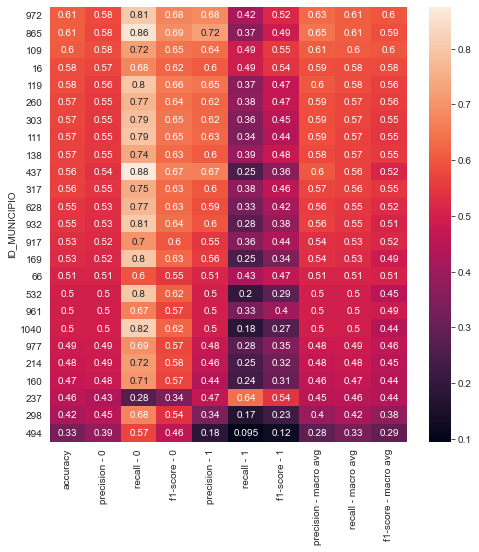

exit to leave:  exit


In [31]:
for name in names: 
    print(name+':')
    fig = plt.figure(figsize=(8, 8)); sns.heatmap(model_scrs_sorted[name], annot=True); plt.show()
    if input('exit to leave: ')=='exit': break
    clear_output(wait=True)

## 5.2 Abandonment Models' Accuracies per City

ID_MUNICIPIO: 917


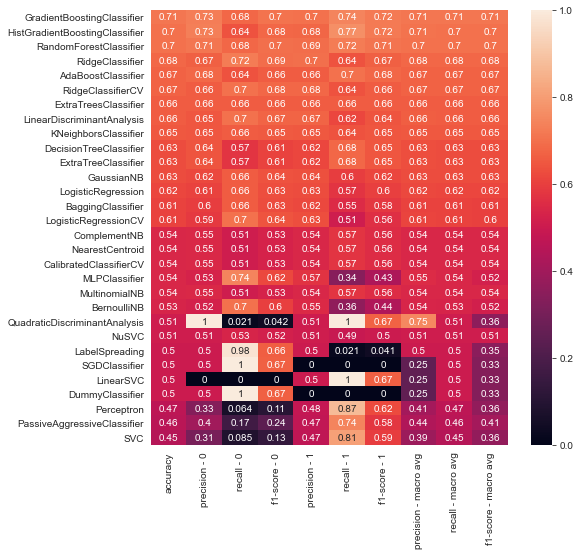

exit to leave:  exit


In [32]:
for city in city_cnt.index: 
    print('ID_MUNICIPIO:', city)
    fig = plt.figure(figsize=(8, 8)); sns.heatmap(city_scrs_sorted[city], annot=True); plt.show()
    if input('exit to leave: ')=='exit': break
    clear_output(wait=True)

## 5.3 Best Model of Each City

In [43]:
best_models = []
for key in city_scrs_sorted.keys():
    
    row = city_scrs_sorted[key].iloc[0]; row.name = str(key) + ' - ' + row.name
    best_models.append(row)

best_models = pd.DataFrame(best_models).sort_values('accuracy', ascending=False)

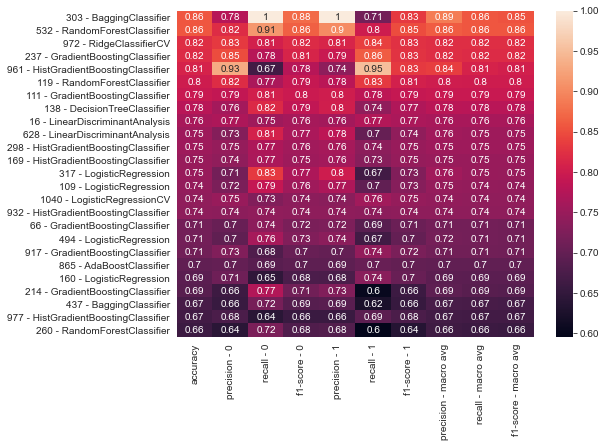

In [55]:
fig = plt.figure(figsize=(8,6)); sns.heatmap(best_models, annot=True); plt.show()

In [57]:
city_data.loc[[303, 532, 972]]

,Student Count,Dropped Out,Never Dropped Out,Never Dropped Out proportion,Train Class Size,Test Class Size
ID_MUNICIPIO,,,,,,
303,1507,1438,69,4.6,55,14
532,2890,2717,173,6.0,138,35
